In [61]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from prince import MCA
import conorm
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "../../"))
sys.path.append(os.path.join(os.getcwd(), "../../nextflow"))
from pca_analysis import plot, rank_models_difference
import plotly.express as px
from gsmmutils.omics.omics_integration import OmicsIntegration 
from gsmmutils.model.COBRAmodel import MyModel
DATA_PATH = "/home/ecunha/omics-integration/data/dsalina/PRJNA437866"
RESULTS_PATH = "/home/ecunha/omics-integration/results/dsalina/PRJNA437866/integration/"
os.chdir(DATA_PATH)

In [62]:
fastcore = pd.read_csv(os.path.join(RESULTS_PATH, "fastcore_local_t2_3_1_2.csv"), index_col=0)
gimme = pd.read_csv(os.path.join(RESULTS_PATH, "gimme_local_t2_3_1_2.csv"), index_col=0)
fastcore = fastcore.astype(int)
gimme = gimme.astype(int)
data = pd.concat([fastcore, gimme])
control = data.filter(regex="^control*", axis=0)
sorb = data.filter(regex="^sorb.*", axis=0)
h2o2 = data.filter(regex="^h2o2.*", axis=0)
nacl = data.filter(regex="^nacl.*", axis=0)

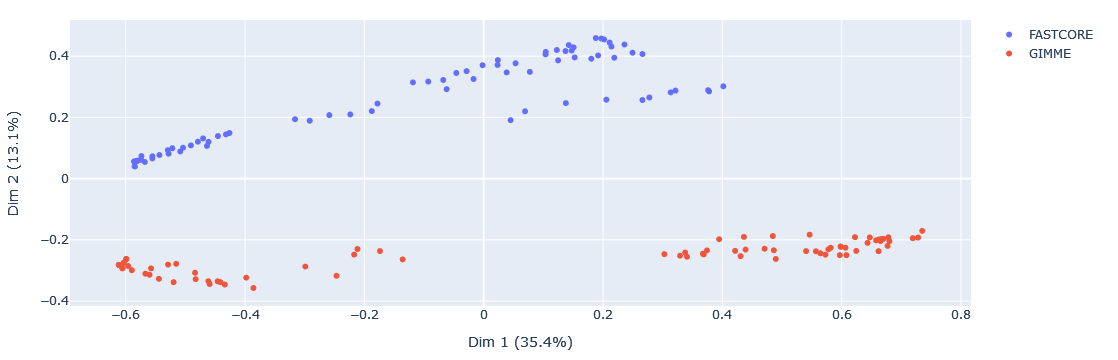

In [63]:
mca = MCA(n_components=3, random_state=42)
data.index = data.index.str.upper()
components = mca.fit_transform(data).to_numpy()
plot(components, [e.split("_")[-2] for e in data.index.tolist()],
    f"Dim 1 ({round(mca.percentage_of_variance_[0], 1)}%)",
    f"Dim 2 ({round(mca.percentage_of_variance_[1], 1)}%)",
    os.path.join(RESULTS_PATH,"mca_models_algorithm_ng"),
    width=1200
)

Top thresholds: ['0.6', '0.8', '0.9', '0.85', '0.7', '0.65', '0.95', '0.5', '0.4', '0.75']


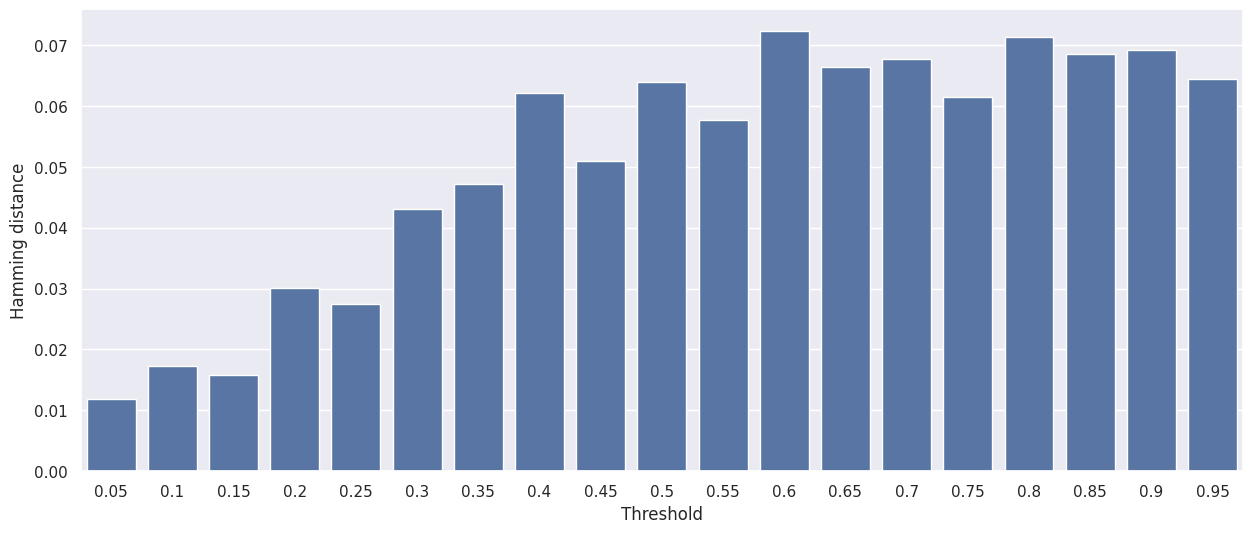

In [64]:
best_thresholds_set = set()
top = 10
data_3_fastcore = fastcore
dist = rank_models_difference(data_3_fastcore)
sorted_thresholds = sorted(dist, key=lambda k: dist[k], reverse=True)
best_thresholds_set.update([float(e) for e in sorted_thresholds[:top]])
print(f"Top thresholds: {sorted_thresholds[:top]}")
data_3_fastcore_filtered = data_3_fastcore[data_3_fastcore.index.str.contains('|'.join([e + "$" for e in sorted_thresholds[:top]]), regex=True)]
ax = sns.barplot(x=dist.keys(), y=dist.values())
ax.set(xlabel='Threshold', ylabel='Hamming distance')
plt.savefig(os.path.join(RESULTS_PATH,"ds_fastcore_3_barplot.pdf"), format="pdf", bbox_inches='tight')

Top thresholds: ['0.4', '0.35', '0.3', '0.6', '0.8', '0.5', '0.65', '0.55', '0.85', '0.2']


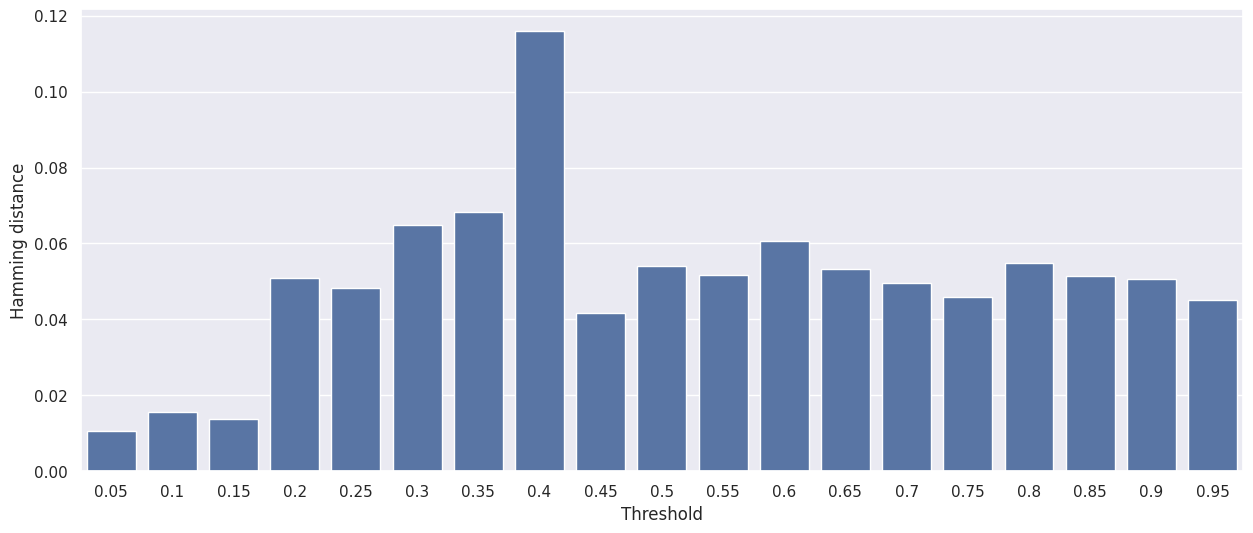

In [65]:
best_thresholds_set = set()
top = 10
data_3_fastcore = gimme
dist = rank_models_difference(data_3_fastcore)
sorted_thresholds = sorted(dist, key=lambda k: dist[k], reverse=True)
best_thresholds_set.update([float(e) for e in sorted_thresholds[:top]])
print(f"Top thresholds: {sorted_thresholds[:top]}")
data_3_fastcore_filtered = data_3_fastcore[data_3_fastcore.index.str.contains('|'.join([e + "$" for e in sorted_thresholds[:top]]), regex=True)]
ax = sns.barplot(x=dist.keys(), y=dist.values())
ax.set(xlabel='Threshold', ylabel='Hamming distance')
plt.savefig(os.path.join(RESULTS_PATH,"ng_fastcore_3_barplot.pdf"), format="pdf", bbox_inches='tight')

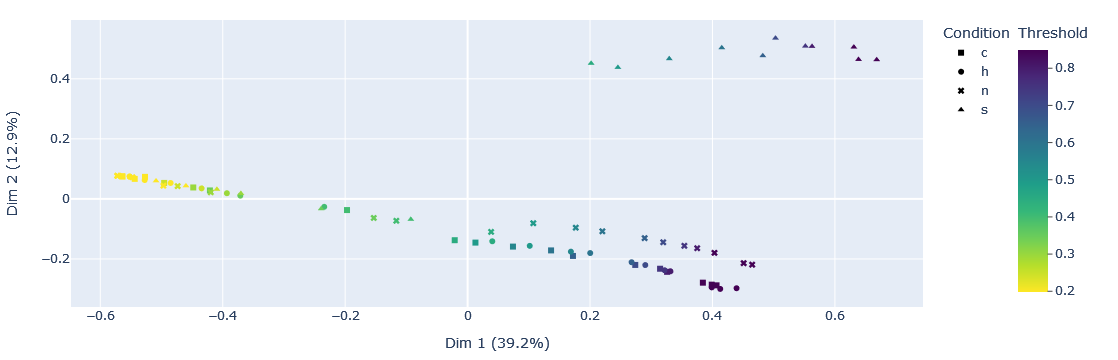

In [59]:
mca = MCA(n_components=3, random_state=42)
components = mca.fit_transform(fastcore).to_numpy()

symbol_list = [e.split("_")[0][0] for e in fastcore.index.tolist()]
symbols = ['square', 'circle', 'x', 'triangle-up']
y = list(float(e.split("_")[-1]) for e in fastcore.index.tolist())
plot(components, y,
    f"Dim 1 ({round(mca.percentage_of_variance_[0],1)}%)",
    f"Dim 2 ({round(mca.percentage_of_variance_[1],1)}%)",
    os.path.join(RESULTS_PATH,"mca_3_fastcore_full_ng"),
    "Condition",
    symbol = symbol_list, symbol_sequence=symbols,
    color_continuous_scale=px.colors.sequential.Viridis_r,
    width=1200,
    range_color=[min(best_thresholds_set), max(best_thresholds_set)]
)

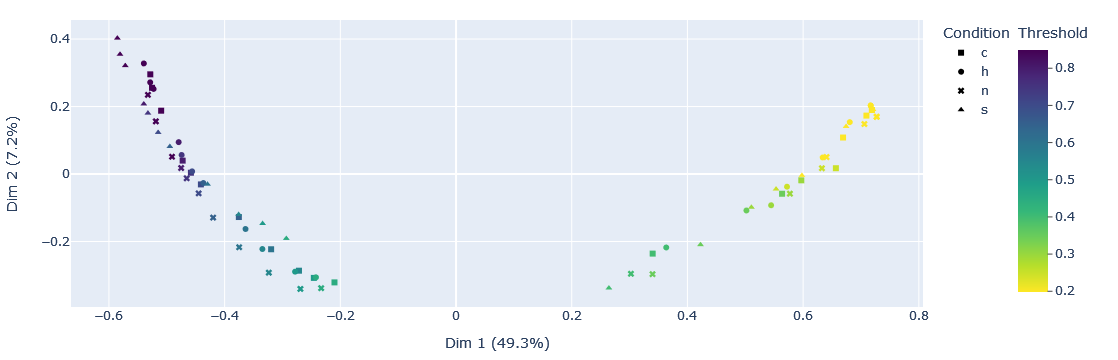

In [60]:
mca = MCA(n_components=3, random_state=42)
components = mca.fit_transform(gimme).to_numpy()

symbol_list = [e.split("_")[0][0] for e in gimme.index.tolist()]
symbols = ['square', 'circle', 'x', 'triangle-up']
y = list(float(e.split("_")[-1]) for e in gimme.index.tolist())
plot(components, y,
    f"Dim 1 ({round(mca.percentage_of_variance_[0],1)}%)",
    f"Dim 2 ({round(mca.percentage_of_variance_[1],1)}%)",
    os.path.join(RESULTS_PATH,"mca_3_fastcore_full_ng"),
    "Condition",
    symbol = symbol_list, symbol_sequence=symbols,
    color_continuous_scale=px.colors.sequential.Viridis_r,
    width=1200,
    range_color=[min(best_thresholds_set), max(best_thresholds_set)]
)